In [13]:
import os
import re
from pathlib import Path
import time
import tqdm

import numpy as np
import pandas as pd 
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sn

import torch 
import torch.nn as nn
import torch.nn.functional
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

register_matplotlib_converters()

FRED Federal Reserve Ecomonic Database 
Sales date of alcohol drinks i millions of dollar from 1992 to 2019

In [19]:
#Importing image dataset into pytorch tensors
transform = transforms.ToTensor()

#To download the dataset set download=True parameter
data_path = Path("./Data/Alcohol_Sales.csv")
data = pd.read_csv(data_path, index_col=0, parse_dates=True)
data

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


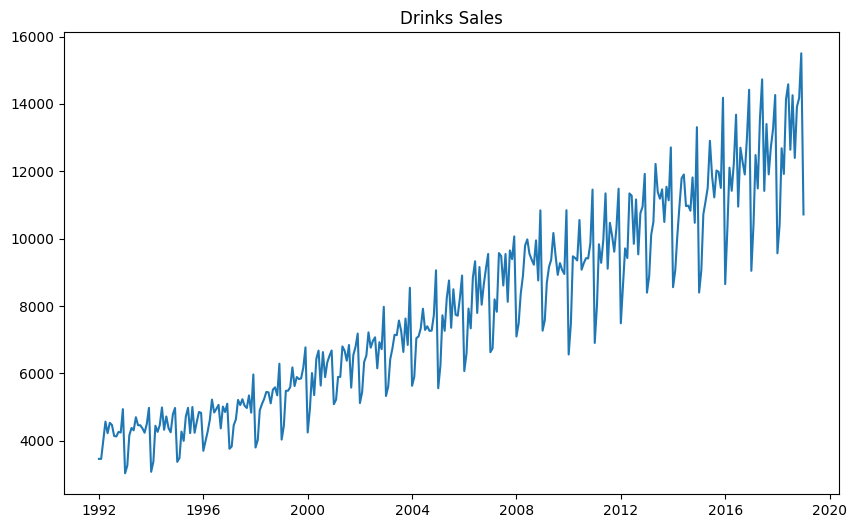

In [20]:
#Format of an image
plt.figure(figsize=(10,6))
plt.title("Drinks Sales")
plt.plot(data)

In [40]:
#Defining data slipts

test_size = int(len(data)*15/100)

column_name = data.columns[0]
train_array = data[column_name][:-test_size].copy().to_numpy()
test_array = data[column_name][-test_size:].copy().to_numpy()


In [49]:
#Normalizing data

scaler = MinMaxScaler(feature_range=(-1,1))

#To avoid data lakage we user the min and max values considering just the train data
scaler.fit(train_array.reshape(-1,1))
train_norm = scaler.transform(train_array.reshape(-1,1))
train_norm = torch.FloatTensor(train_norm).view(-1)




In [ ]:
#The window size should be at least one cycle 

window_size = 12 #One year window size

def input_data(data, window_size):
    out=[]
    L = len(data)

    for i in range(L-window_size):
        window = data[i:i+window_size]
        label = data[i+window_size: i+window_size+1]
        out.append((window, label))
    
    return out

train_data = input_data(train_norm, window_size)
print(train_data)


In [58]:

class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        #Add an LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1,1,self.hidden_size),  #To predict just one output per sequence
                    torch.zeros(1,1,self.hidden_size))
    
    def forward(self, data):

        lstm_out, self.hidden = self.lstm(data.view(len(data),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(data)), -1)

        return pred[-1] #We only want the last data of the predicted sequence

    
#Initialing model
torch.manual_seed(101)
model = LSTM(input_size=1, hidden_size=100, output_size=1) #One input data and one output per sequence 

#Print model configuration
print(f"\tModule name \t\t| \t Parameters Listed")
for name, parameter in model.named_parameters():
    print(f'\t {name} \t| \t {parameter.numel()}')


#Defining loss function and optmizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


	Module name 		| 	 Parameters Listed
	 lstm.weight_ih_l0 	| 	 400
	 lstm.weight_hh_l0 	| 	 40000
	 lstm.bias_ih_l0 	| 	 400
	 lstm.bias_hh_l0 	| 	 400
	 linear.weight 	| 	 100
	 linear.bias 	| 	 1
